In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from matplotlib.colors import Normalize

In [2]:
filename = os.path.expandvars("$SCRATCH/data/transient_spirals/04-base-new-init/base-new-init_99.fits")
data = Table.read(filename, format='fits')

In [3]:
R, vR, vT, z, vz, phi = data['R', 'vR', 'vT', 'z', 'vz', 'phi'].as_array().view((np.float64, 6)).T
phi[phi > np.pi] -= 2*np.pi
del data

In [4]:
mask = (R > 3/8.) & (R < 13/8.) & (phi > -np.pi/18) & (phi < np.pi/18) & (vT > 0.1) & (vT < 1.7)
H, xedges, yedges = np.histogram2d(R[mask], vT[mask], bins=500)
H = H.T

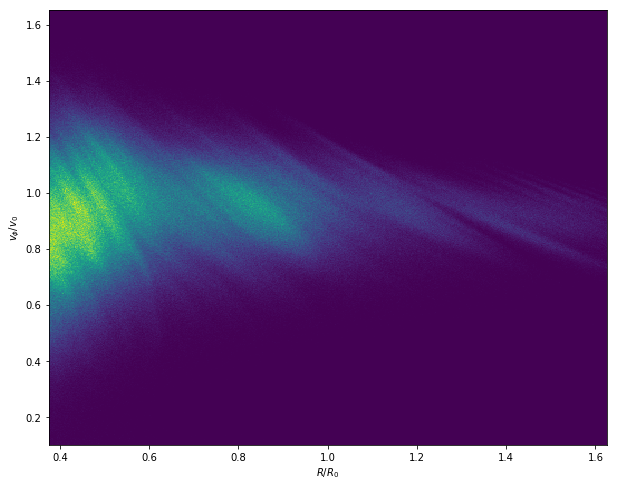

In [5]:
plt.figure(figsize=(10,8))
plt.imshow(H, origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
plt.xlabel('$R/R_0$')
plt.ylabel('$v_{\phi}/v_0$')
plt.show()

# Colour By Angular Momentum

In [6]:
lz = R * vT

In [7]:
lz_bins = np.histogram2d(R[mask], vT[mask], bins=(xedges, yedges), weights=lz[mask])[0]
lz_bins = lz_bins.T

In [8]:
lz_mean_bins = lz_bins/H

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


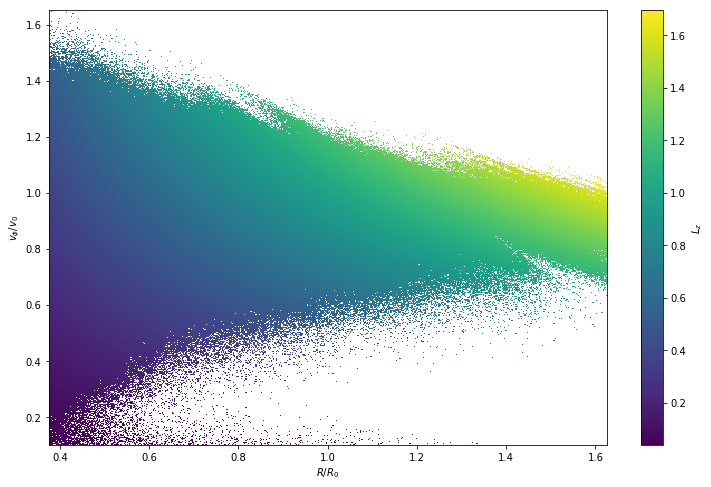

In [9]:
plt.figure(figsize=(12.5,8))
plt.imshow(lz_mean_bins, origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
plt.xlabel('$R/R_0$')
plt.ylabel('$v_{\phi}/v_0$')
plt.colorbar(label = '$L_z$')
plt.show()

# Colour by Kinetic Energy

In [10]:
T = (vR**2 + vT**2 + vz**2) / 2

In [11]:
T_bins = np.histogram2d(R[mask], vT[mask], bins=(xedges, yedges), weights=T[mask])[0]
T_bins = T_bins.T

In [12]:
T_mean_bins = T_bins/H

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


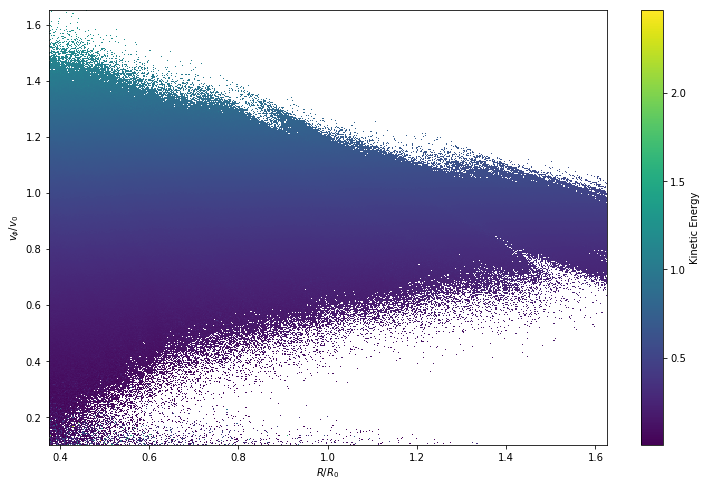

In [13]:
plt.figure(figsize=(12.5,8))
plt.imshow(T_mean_bins, origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
plt.xlabel('$R/R_0$')
plt.ylabel('$v_{\phi}/v_0$')
plt.colorbar(label = 'Kinetic Energy')
plt.show()

# Colour by Total Energy

In [14]:
from galpy.potential import evaluatePotentials, MWPotential2014, DehnenBarPotential, SpiralArmsPotential, CorotatingRotationWrapperPotential, GaussianAmplitudeWrapperPotential
from galpy.util.multi import parallel_map

# Vantage point coordinates
ro = 8.
vo = 220.

# Bar parameters
tform = -10.            # Bar periods
tsteady = 5.            # Bar periods, slowly grown
omega = 1.3             # Pattern speed of the bar
angle = 25./180.*np.pi  # Bar angle
rb = 5./8.              # Bar radius
Af = 1./75.             # Bar strength

# Bar potential
dp = DehnenBarPotential(omegab=omega, rb=rb, Af=Af, tform=tform, tsteady=tsteady, barphi=angle)

# Spiral parameters
N = 2                       # Number of arms
amp = 1.                    # Amplitude
phi_ref = 25.*np.pi/180.    # Reference angle
alpha = np.deg2rad(12.)     # Pitch angle
to = dp.tform()/3.75        # Formation time for first arm
lifetimeS = 1.3             # Lifetime

# Spiral potential at peak
sp = SpiralArmsPotential(N=N, amp=amp, phi_ref=phi_ref, alpha=alpha)

# Corotating spiral potentials
csp = GaussianAmplitudeWrapperPotential(
        pot=CorotatingRotationWrapperPotential(pot=sp, vpo=1., to=to, beta=0., pa=1.3*to),
        to=to, sigma=lifetimeS)
csp3 = GaussianAmplitudeWrapperPotential(
        pot=CorotatingRotationWrapperPotential(pot=sp, vpo=1., to=to/2., beta=0., pa=1.3*to),
        to=to/2., sigma=lifetimeS)
csp5 = GaussianAmplitudeWrapperPotential(
        pot=CorotatingRotationWrapperPotential(pot=sp, vpo=1., to=0., beta=0., pa=1.3*to),
        to=0., sigma=lifetimeS)

# Overall potential
pot = [MWPotential2014, dp, csp, csp3, csp5]

In [15]:
def evaluatePotentialsParallel(i):
    return evaluatePotentials(pot, R[i], z[i], phi=phi[i], t=0)

In [16]:
U = np.array(parallel_map(evaluatePotentialsParallel, np.where(mask)[0], numcores=40))

In [17]:
E = U + T[mask]

In [18]:
E_bins = np.histogram2d(R[mask], vT[mask], bins=(xedges, yedges), weights=E)[0]
E_bins = E_bins.T

In [19]:
E_mean_bins = E_bins/H

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.



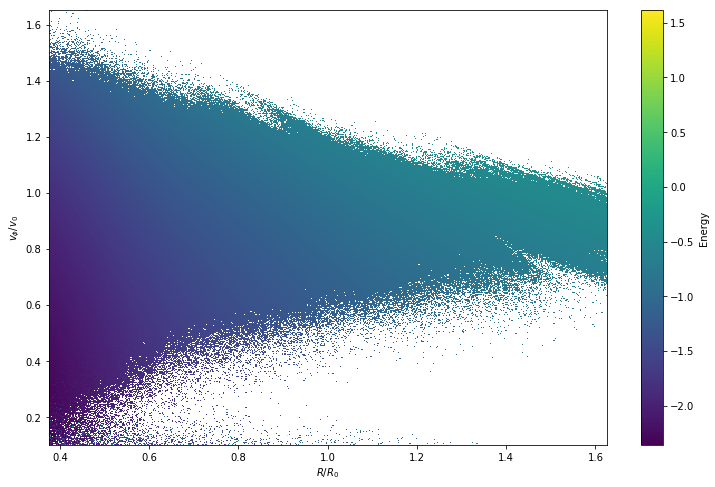

In [20]:
plt.figure(figsize=(12.5,8))
plt.imshow(E_mean_bins, origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
plt.xlabel('$R/R_0$')
plt.ylabel('$v_{\phi}/v_0$')
plt.colorbar(label = 'Energy')
plt.show()

# Colour by Potential Energy

In [21]:
U_bins = np.histogram2d(R[mask], vT[mask], bins=(xedges, yedges), weights=U)[0]
U_bins = U_bins.T

In [22]:
U_mean_bins = U_bins/H

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.



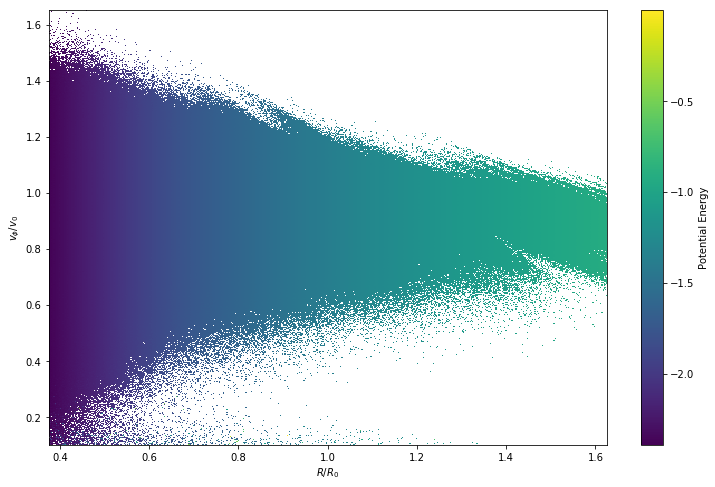

In [23]:
plt.figure(figsize=(12.5,8))
plt.imshow(U_mean_bins, origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
plt.xlabel('$R/R_0$')
plt.ylabel('$v_{\phi}/v_0$')
plt.colorbar(label = 'Potential Energy')
plt.show()

# Colour by $v_R$

In [5]:
vR_bins = np.histogram2d(R[mask], vT[mask], bins=(xedges, yedges), weights=vR[mask])[0]
vR_bins = vR_bins.T

In [6]:
vR_mean_bins = vR_bins/H

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


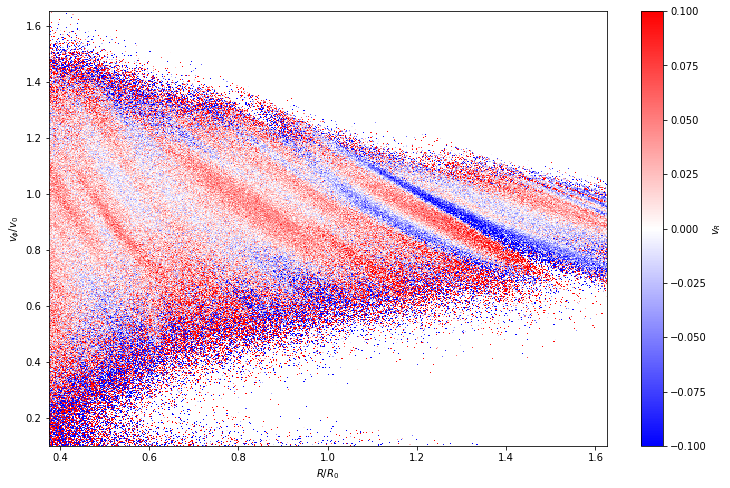

In [9]:
plt.figure(figsize=(12.5,8))
plt.imshow(vR_mean_bins, origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', vmin=-0.1, vmax=0.1, cmap='bwr')
plt.xlabel('$R/R_0$')
plt.ylabel('$v_{\phi}/v_0$')
plt.colorbar(label = '$v_R$')
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until



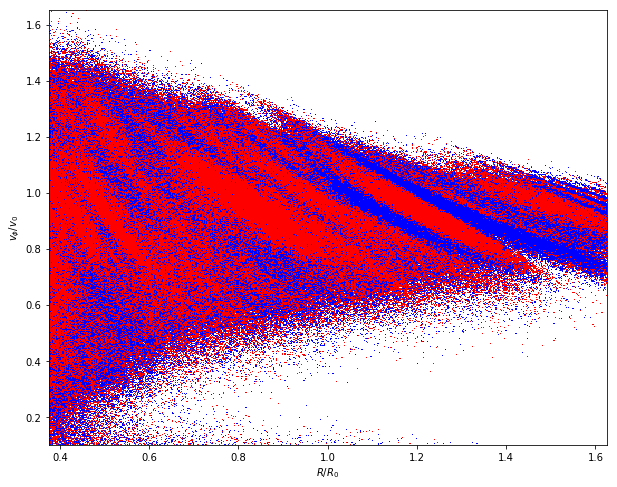

In [133]:
H_cutoff = np.copy(vR_mean_bins)
H_cutoff[H_cutoff < 0] = 0
H_cutoff[H_cutoff > 0] = 1

plt.figure(figsize=(10,8))
plt.imshow(H_cutoff, origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', vmin=0, vmax=1, cmap='bwr')
plt.xlabel('$R/R_0$')
plt.ylabel('$v_{\phi}/v_0$')
plt.show()

# Normalized by Radial Position

In [134]:
M = np.nanmax(H, axis=0)
m = np.nanmin(H, axis=0)
H_normed = (H - m.T) / (M - m)

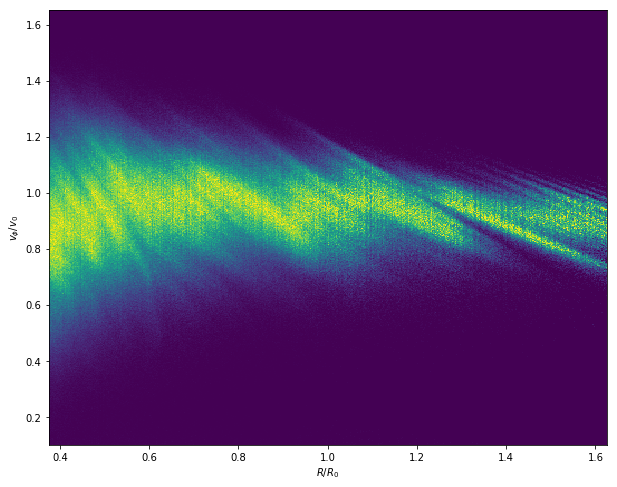

In [135]:
plt.figure(figsize=(10,8))
plt.imshow(H_normed, origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
plt.xlabel('$R/R_0$')
plt.ylabel('$v_{\phi}/v_0$')
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until



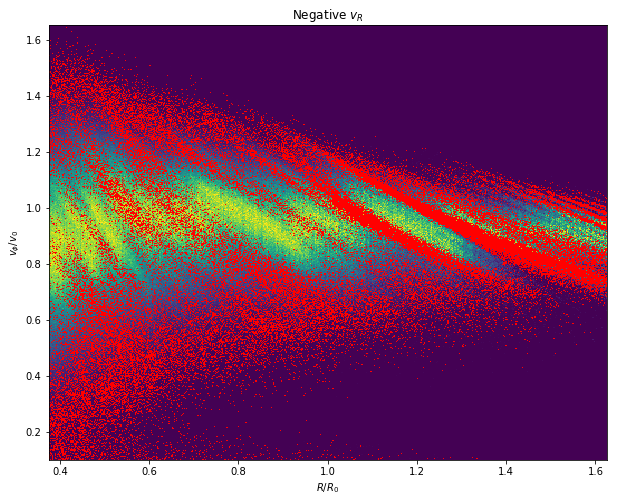

In [143]:
H_cutoff = np.copy(vR_mean_bins)
H_cutoff[H_cutoff > 0] = np.nan
H_cutoff[H_cutoff < 0] = 1

plt.figure(figsize=(10,8))
plt.imshow(H_normed, origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
plt.imshow(H_cutoff, origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='bwr', vmin=0, vmax=1)
plt.xlabel('$R/R_0$')
plt.ylabel('$v_{\phi}/v_0$')
plt.title('Negative $v_R$')
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until



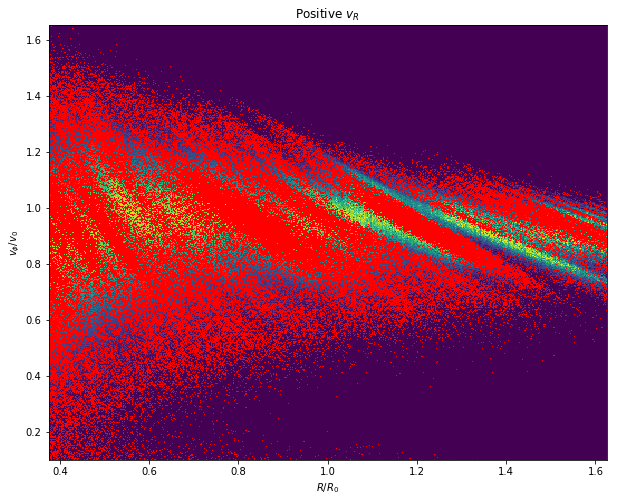

In [144]:
H_cutoff = np.copy(vR_mean_bins)
H_cutoff[H_cutoff < 0] = np.nan
H_cutoff[H_cutoff > 0] = 1

plt.figure(figsize=(10,8))
plt.imshow(H_normed, origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
plt.imshow(H_cutoff, origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='bwr', vmin=0, vmax=1)
plt.xlabel('$R/R_0$')
plt.ylabel('$v_{\phi}/v_0$')
plt.title('Positive $v_R$')
plt.show()

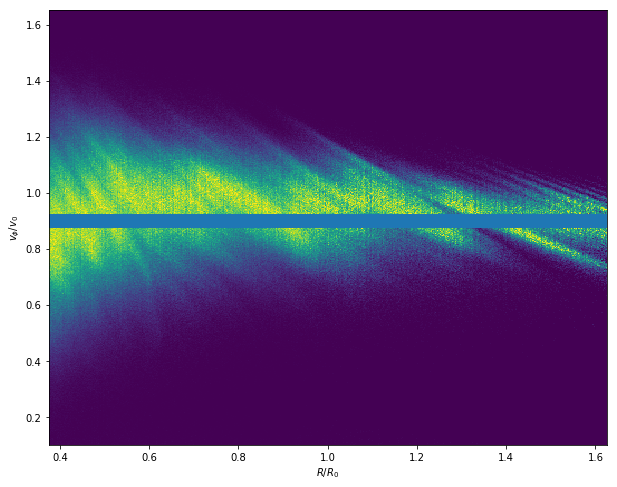

In [138]:
plt.figure(figsize=(10,8))
plt.imshow(H_normed, origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
plt.xlabel('$R/R_0$')
plt.ylabel('$v_{\phi}/v_0$')
plt.axhspan(0.875,0.925)
plt.show()

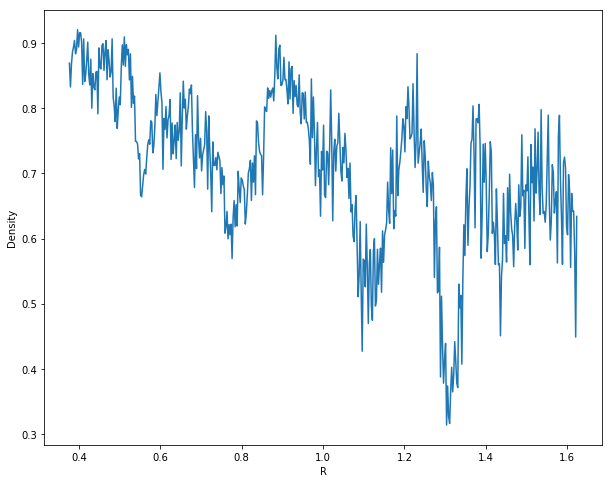

In [139]:
R_densities = np.mean(H_normed[np.where((yedges > 0.875) & (yedges < 0.925))[0]], axis=0)
x_centres = (xedges[1:] + xedges[:-1]) / 2
plt.figure(figsize=(10,8))
plt.plot(x_centres, R_densities)
plt.xlabel('R')
plt.ylabel('Density')
plt.show()

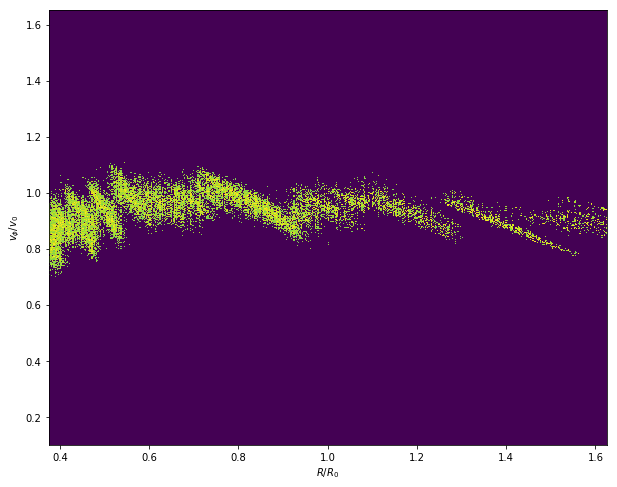

In [140]:
H_cutoff = np.copy(H_normed)
H_cutoff[H_cutoff < 0.8] = 0
plt.figure(figsize=(10,8))
plt.imshow(H_cutoff, origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
plt.xlabel('$R/R_0$')
plt.ylabel('$v_{\phi}/v_0$')
plt.show()